In [28]:
import scipy.io as sio
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})
sns.set_style("whitegrid")
%matplotlib inline
from collections import defaultdict
from numpy import mean
from numpy import std
import shap
import time
import numpy as np
import pandas as pd
import scipy.io as sio
from scipy.fftpack import fft
from IPython.display import display
from scipy import stats
import scipy.stats
import itertools
from matplotlib import pyplot
from xgboost import XGBClassifier, plot_importance
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score
import shap
import imblearn.over_sampling
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import NearMiss
import sklearn
from numpy import where
from xgboost import plot_importance
plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'

In [57]:
def run_test(X_train,y_train, X_test, y_test):
  
    #define the model 
    clf = XGBClassifier(use_label_encoder=False, verbosity=0)
    
    #create undersampler 
    rus = RandomUnderSampler(random_state=42, replacement=True)
    
    #fit the undersample
    X_rus, y_rus = rus.fit_resample(X_train, y_train)
    
    #print the original data set shape & new undersample
    print('original dataset shape:', Counter(y_train))
    print('Resample dataset shape', Counter(y_rus))
    
   
    #fit the model on training data 
    clf.fit(X_rus, y_rus)
  
    
    #predict the on the test set
    y_pred = clf.predict(X_test)
    
    #create output of predictions
    predictions = pd.DataFrame(y_pred, columns = ['ouput'])
    predictions["y_true_value"] = y_test.values
    predictions['model'] = 'XG Boost'

    
    #calculate test score 
    test_score = accuracy_score(y_test,y_pred)
    
    #calculate precision score
    precision = precision_score(y_test, y_pred, average='binary')
    
    #calculate recall 
    recall = recall_score(y_test, y_pred, average='binary')
    
    #calculate F score
    f_score = f1_score(y_test, y_pred, average='binary')
    
    # predict probabilities
    cl_probs = clf.predict_proba(X_test)
    
    # generate a no skill prediction (majority class)
    ns_probs = [0 for _ in range(len(y_test))]
    
    # keep probabilities for the positive outcome only
    cl_probs = cl_probs[:, 1]
    
    # calculate auc scores
    ns_auc = roc_auc_score(y_test, ns_probs)
    cl_auc = roc_auc_score(y_test, cl_probs)
    
    # summarize auc scores
    print('No Skill: ROC AUC=%.3f' % (ns_auc))
    print('XG Boost: ROC AUC=%.3f' % (cl_auc))
    
    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
    lr_fpr, lr_tpr, _ = roc_curve(y_test, cl_probs)
    
    # plot the roc curve for the model
    
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    plt.plot(lr_fpr, lr_tpr, marker='.', label= 'XG Boost')
    
    # axis labels
    pyplot.xlabel('False Positive Rate')
    pyplot.ylabel('True Positive Rate')
    
    # show the legend
    pyplot.legend()
    
    #titles
    plt.title("XGBoost ROC Curve")
    
    #save the plt
    plt.savefig('XGBoost_final_corr.png', dpi=400)
    
    # show the plot
    pyplot.show()

    
    #print confusion matrix 
    cm = confusion_matrix(y_test, y_pred)
    
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix for XGBoost on EEG Test Data'); 
    ax.xaxis.set_ticklabels([ 'interical', 'preictal']); ax.yaxis.set_ticklabels(['interictal', 'preictal']);
    plt.savefig("'Confusion_matrix_XGBoost_final.png", dpi=400)
    
    print("\nThe Accuracy Score is {}".format(test_score),
         "\nThe Precision Score is {}".format(precision),
         "\nThe Recall Score is {}".format(recall),
         "\nThe F Score is {}".format(f_score))
    
    # plot feature importance
    plot_importance(clf)
    plt.tight_layout()
    plt.title("Feature Importance for XGBoost on EEG Test Data")
    plt.savefig("feature_importance.png", dpi=400)

    
    return predictions

In [58]:
#load training data

train_data = pd.read_csv("train.csv")


In [59]:
#load test data

test_data = pd.read_csv("test.csv")


In [60]:
#train and test 

#drop recording labels for modeling 
cols = ['Recording']
train_df = train_data.drop(cols, axis=1)


X_train = train_df.drop('y', axis=1)
y_train = train_df['y']

rus = RandomUnderSampler(random_state=42, replacement=True)
X_rus, y_rus = rus.fit_resample(X_train, y_train)


#drop recording labels for modeling 
cols = ['Recording']
test_df = test_data.drop(cols, axis=1)


#create X and y 

X_test = test_df.drop('y', axis=1)
y_test = test_df['y']




original dataset shape: Counter({0.0: 3724, 1.0: 259})
Resample dataset shape Counter({0.0: 259, 1.0: 259})
No Skill: ROC AUC=0.500
XG Boost: ROC AUC=0.841


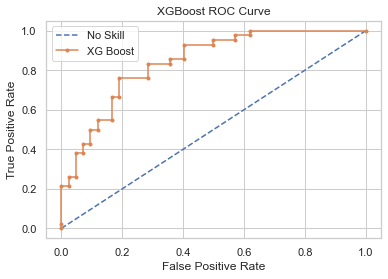


The Accuracy Score is 0.75 
The Precision Score is 0.7333333333333333 
The Recall Score is 0.7857142857142857 
The F Score is 0.7586206896551724


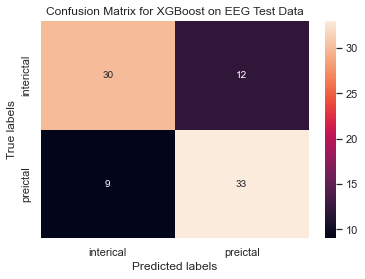

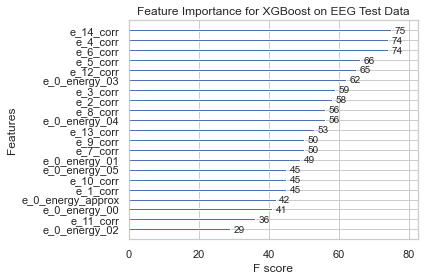

In [61]:
xgb_final = run_test(X_train, y_train, X_test, y_test)

In [62]:
xgb_final

,ouput,y_true_value,model
0,1,1.0,XG Boost
1,0,1.0,XG Boost
2,0,1.0,XG Boost
3,1,1.0,XG Boost
4,0,1.0,XG Boost
...,...,...,...
79,1,0.0,XG Boost
80,1,0.0,XG Boost
81,1,0.0,XG Boost
82,1,0.0,XG Boost


In [63]:
review = xgb_final.join(test_data, how='outer')

In [64]:
review[review['ouput']!=review['y_true_value']]

,ouput,y_true_value,model,Recording,e_1_corr,e_2_corr,e_3_corr,e_4_corr,e_5_corr,e_6_corr,...,e_13_corr,e_14_corr,e_0_energy_approx,e_0_energy_05,e_0_energy_04,e_0_energy_03,e_0_energy_02,e_0_energy_01,e_0_energy_00,y
1,0,1.0,XG Boost,Dog_1_preictal_segment_0020.mat,0.426407,-0.250139,-0.348372,0.699514,0.411132,-0.166363,...,-0.482592,-0.478116,2.343607e+07,1.717572e+07,2.759323e+07,3.565193e+07,3.008969e+07,1.575794e+07,4.967351e+06,1.0
2,0,1.0,XG Boost,Dog_1_preictal_segment_0021.mat,0.426958,-0.193292,-0.352829,0.698869,0.503942,-0.134583,...,-0.538571,-0.536777,8.952535e+07,5.567913e+07,5.254949e+07,5.777804e+07,3.049509e+07,1.119168e+07,3.460386e+06,1.0
4,0,1.0,XG Boost,Dog_1_preictal_segment_0023.mat,0.440229,-0.247100,-0.354956,0.689467,0.400496,-0.170305,...,-0.467555,-0.471510,1.387218e+07,1.205427e+07,1.855285e+07,2.321299e+07,2.289307e+07,1.703629e+07,5.260480e+06,1.0
5,0,1.0,XG Boost,Dog_1_preictal_segment_0024.mat,0.411611,-0.214554,-0.325279,0.625493,0.405816,-0.138279,...,-0.468674,-0.476897,2.661474e+07,1.716641e+07,2.429992e+07,2.790610e+07,2.209979e+07,1.341330e+07,4.398005e+06,1.0
6,1,0.0,XG Boost,Dog_1_interictal_segment_0265.mat,0.444305,-0.071879,-0.156866,0.616683,0.407810,-0.037449,...,-0.291151,-0.263089,2.543378e+07,7.928225e+06,6.999233e+06,7.125207e+06,2.203278e+07,1.610545e+07,4.653853e+06,0.0
7,1,0.0,XG Boost,Dog_1_interictal_segment_0266.mat,0.470844,-0.105468,-0.176744,0.706473,0.455754,-0.001450,...,-0.354217,-0.248945,1.046337e+07,5.036347e+06,5.232579e+06,6.925555e+06,2.525925e+07,1.557576e+07,3.810823e+06,0.0
29,0,1.0,XG Boost,Dog_3_preictal_segment_0006.mat,0.087918,-0.024408,0.000327,-0.027297,-0.009631,-0.068423,...,-0.070415,-0.128210,3.815457e+07,2.532007e+07,2.884041e+07,3.438805e+07,2.872249e+07,1.641966e+07,5.423935e+06,1.0
36,0,1.0,XG Boost,Dog_4_preictal_segment_0001.mat,0.137145,-0.519418,-0.576267,0.755856,0.198730,-0.355495,...,0.153887,-0.502807,1.571237e+08,3.342772e+08,8.159809e+08,5.186695e+08,1.539619e+08,3.935126e+07,1.056053e+07,1.0
41,0,1.0,XG Boost,Dog_4_preictal_segment_0006.mat,0.116923,-0.517231,-0.563683,0.733803,0.169113,-0.366322,...,0.172763,-0.444342,1.148444e+08,3.000291e+08,6.747178e+08,3.957421e+08,1.267407e+08,3.842260e+07,1.038925e+07,1.0
43,1,0.0,XG Boost,Dog_4_interictal_segment_0008.mat,0.225058,-0.381661,-0.430222,0.728885,0.249743,-0.286278,...,0.001581,-0.411307,1.155224e+08,1.833299e+08,5.310394e+08,3.381822e+08,1.429809e+08,4.617469e+07,1.242275e+07,0.0
